# **Laboratorio 7 | Predicción de Diabetes con AutoGluon**

- Diego Duarte
- Paula Barillas 

### **Librerías**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from autogluon.tabular import TabularPredictor

plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings("ignore")

C:\Users\rebe1\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Importación de datos**

In [2]:
data_path = "./data/diabetes.csv"
data = pd.read_csv(data_path)
print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


### **Preparación de datos y Análisis Exploratorio de Datos**

#### **1.1 Descripción de las variables del conjunto de datos**

In [3]:
print("=== INFORMACIÓN DEL DATASET ===")
print(f"Dimensiones del dataset: {data.shape}")
print(f"Número de filas: {data.shape[0]}")
print(f"Número de columnas: {data.shape[1]}")
print("\n=== INFORMACIÓN DE COLUMNAS ===")
print(data.info())
print("\n=== PRIMERAS 5 FILAS ===")
print(data.head())

=== INFORMACIÓN DEL DATASET ===
Dimensiones del dataset: (768, 9)
Número de filas: 768
Número de columnas: 9

=== INFORMACIÓN DE COLUMNAS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

=== PRIMERAS 5 FILAS ===
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BM

**Descripción de las variables:**

- **Pregnancies**: Número de veces que ha estado embarazada
- **Glucose**: Concentración de glucosa en plasma
- **BloodPressure**: Presión arterial diastólica (mm Hg)
- **SkinThickness**: Grosor del pliegue cutáneo del tríceps (mm)
- **Insulin**: Insulina sérica a las 2 horas (mu U/ml)
- **BMI**: Índice de masa corporal (peso en kg/(altura en m)^2)
- **DiabetesPedigreeFunction**: Función de pedigrí de diabetes (probabilidad de diabetes basada en antecedentes familiares)
- **Age**: Edad (años)
- **Outcome**: Variable objetivo - 1 si tiene diabetes, 0 si no tiene diabetes

**Contexto**: La columna 'Outcome' representa si el paciente tiene (1) o no tiene (0) diabetes. Representando clasificación binaria.

#### **2.1 Estadísticas descriptivas básicas**

In [4]:
# eestadísticas descriptivas
print("=== ESTADÍSTICAS DESCRIPTIVAS ===")
descriptive_stats = data.describe()
print(descriptive_stats)

# tipos de datosss
print("\n=== TIPOS DE DATOS ===")
print(data.dtypes)

=== ESTADÍSTICAS DESCRIPTIVAS ===
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
m

#### **2.2 Verificación de valores nulos y ceros**

In [5]:
# valores nulos
print("=== VALORES NULOS ===")
null_values = data.isnull().sum()
print(null_values)

# posibles valores ceros
print("\n=== VALORES CEROS ===")
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zero_values = (data[columns_to_check] == 0).sum()
print(zero_values)

print(f"\nTotal de registros con valores ceros: {(data[columns_to_check] == 0).any(axis=1).sum()}")

=== VALORES NULOS ===
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

=== VALORES CEROS ===
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Total de registros con valores ceros: 376


#### **2.3 Tratamiento de valores ceros problemáticos**

In [6]:
# Reemplazar ceros con NaN 
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[columns_to_replace] = data[columns_to_replace].replace(0, pd.NA)

# Suprimir advertencias específicas
warnings.filterwarnings("ignore", category=FutureWarning, message="Downcasting object dtype arrays on .fillna")

# Rellenar valores faltantes con la mediana de cada columna
for column in columns_to_replace:
    median_value = data[column].median(skipna=True)
    data[column] = data[column].fillna(median_value)
    print(f"{column}: mediana = {median_value:.2f}")

# Verificar que no hay valores nulos
print(f"\n=== VERIFICACIÓN VALORES NILOS ===")
print("Valores nulos después de reemplazo:")
print(data.isnull().sum())

#  tipos de datos
print(f"\n=== TIPOS DE DATOS ACTUALIZADOS ===")
print(data.dtypes)

Glucose: mediana = 117.00
BloodPressure: mediana = 72.00
SkinThickness: mediana = 29.00
Insulin: mediana = 125.00
BMI: mediana = 32.30

=== VERIFICACIÓN VALORES NILOS ===
Valores nulos después de reemplazo:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

=== TIPOS DE DATOS ACTUALIZADOS ===
Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


En este dataset algunos valores aparecen como cero en variables como glucosa, presión sanguínea, insulina o IMC, estos no son posibles y se consideran datos faltantes. Por ello, se reemplazaron por valores nulos (NaN) y posteriormente se imputaron con la mediana de cada variable. En otros casos se podrían emplear otros métodos de imputación, como KNN Imputer, la media o la eliminación de registros. Sin embargo, la imputación con mediana conserva el tamaño del dataset y reduce el sesgo por valores atípicos.

#### **2.4 Visualización de distribuciones**

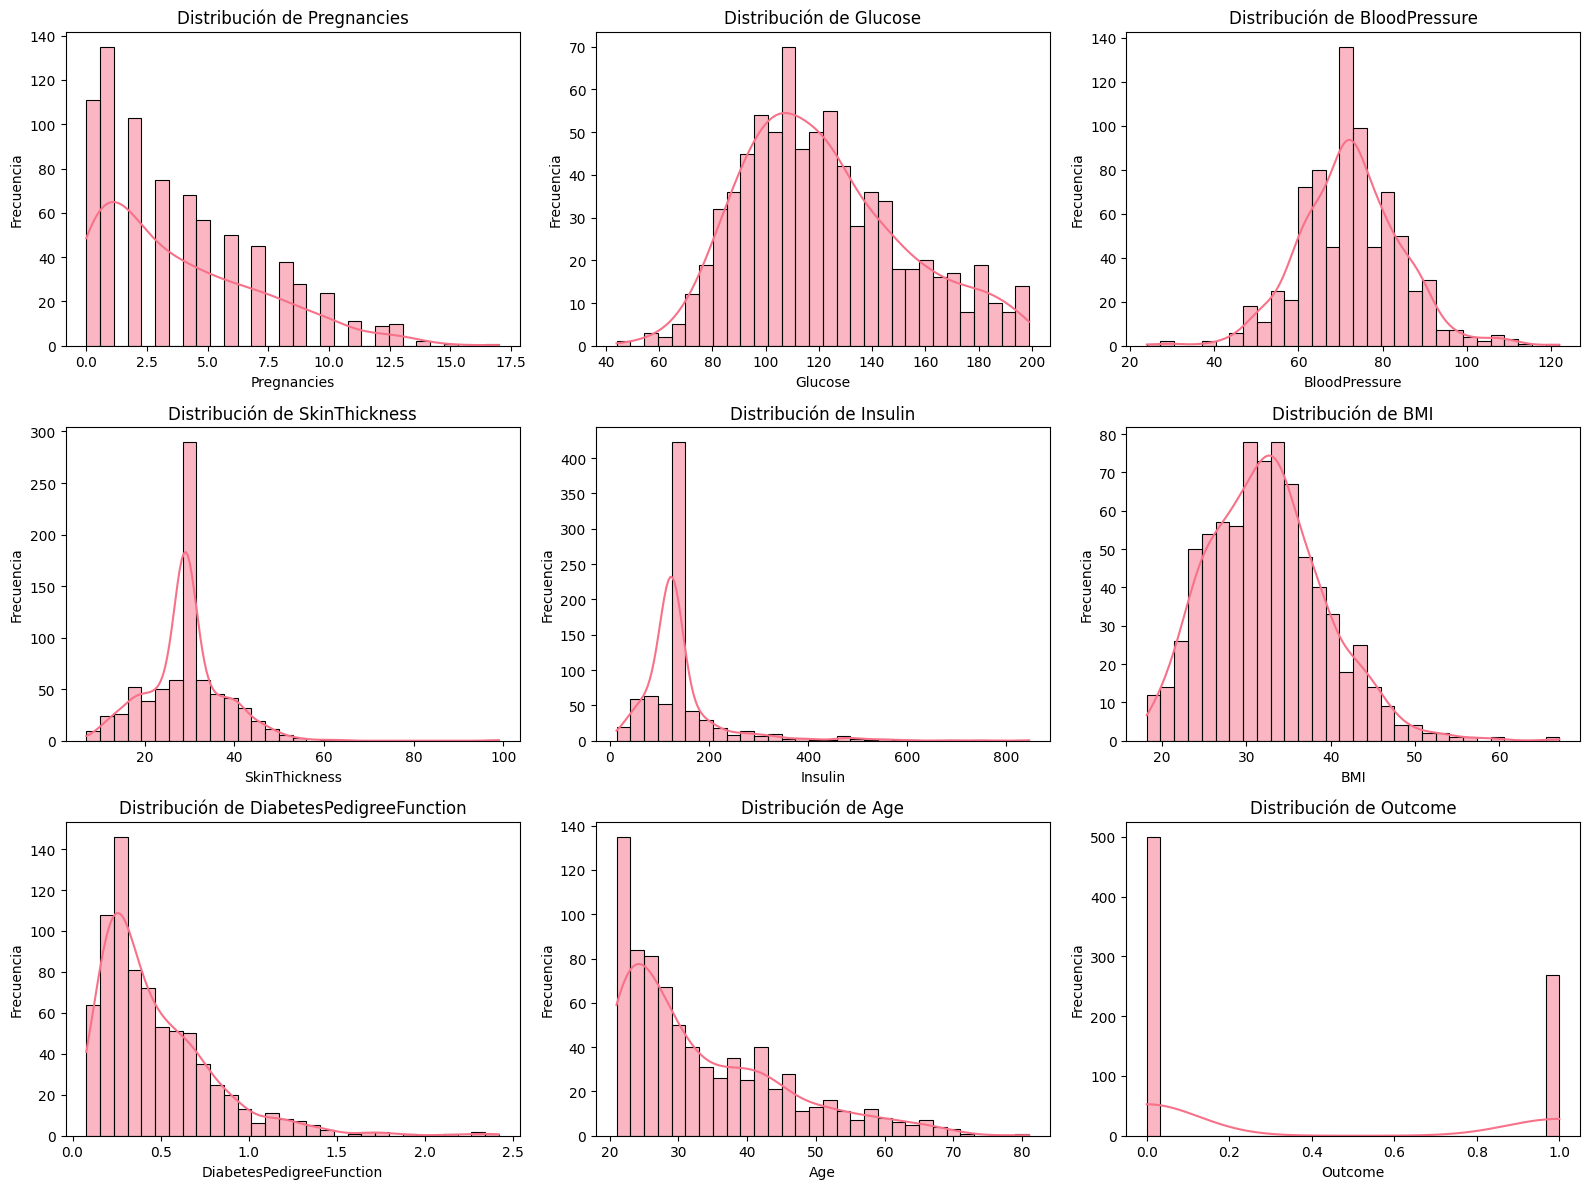

=== ESTADÍSTICAS DESCRIPTIVAS DESPUÉS DE LIMPIEZA ===
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  140.671875   
std       3.369578   30.438286      12.096642       8.791221   86.383060   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208                  0.471876   33.240885    0.348958  
std      6.875177                  0.331329   11.76

In [7]:
# distribuciones
plt.figure(figsize=(16, 12))
for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Estadísticas descriptivas actualizadas después de la limpieza
print("=== ESTADÍSTICAS DESCRIPTIVAS DESPUÉS DE LIMPIEZA ===")
print(data.describe())

#### **2.5 Visualización de valores atípicos - Boxplots**

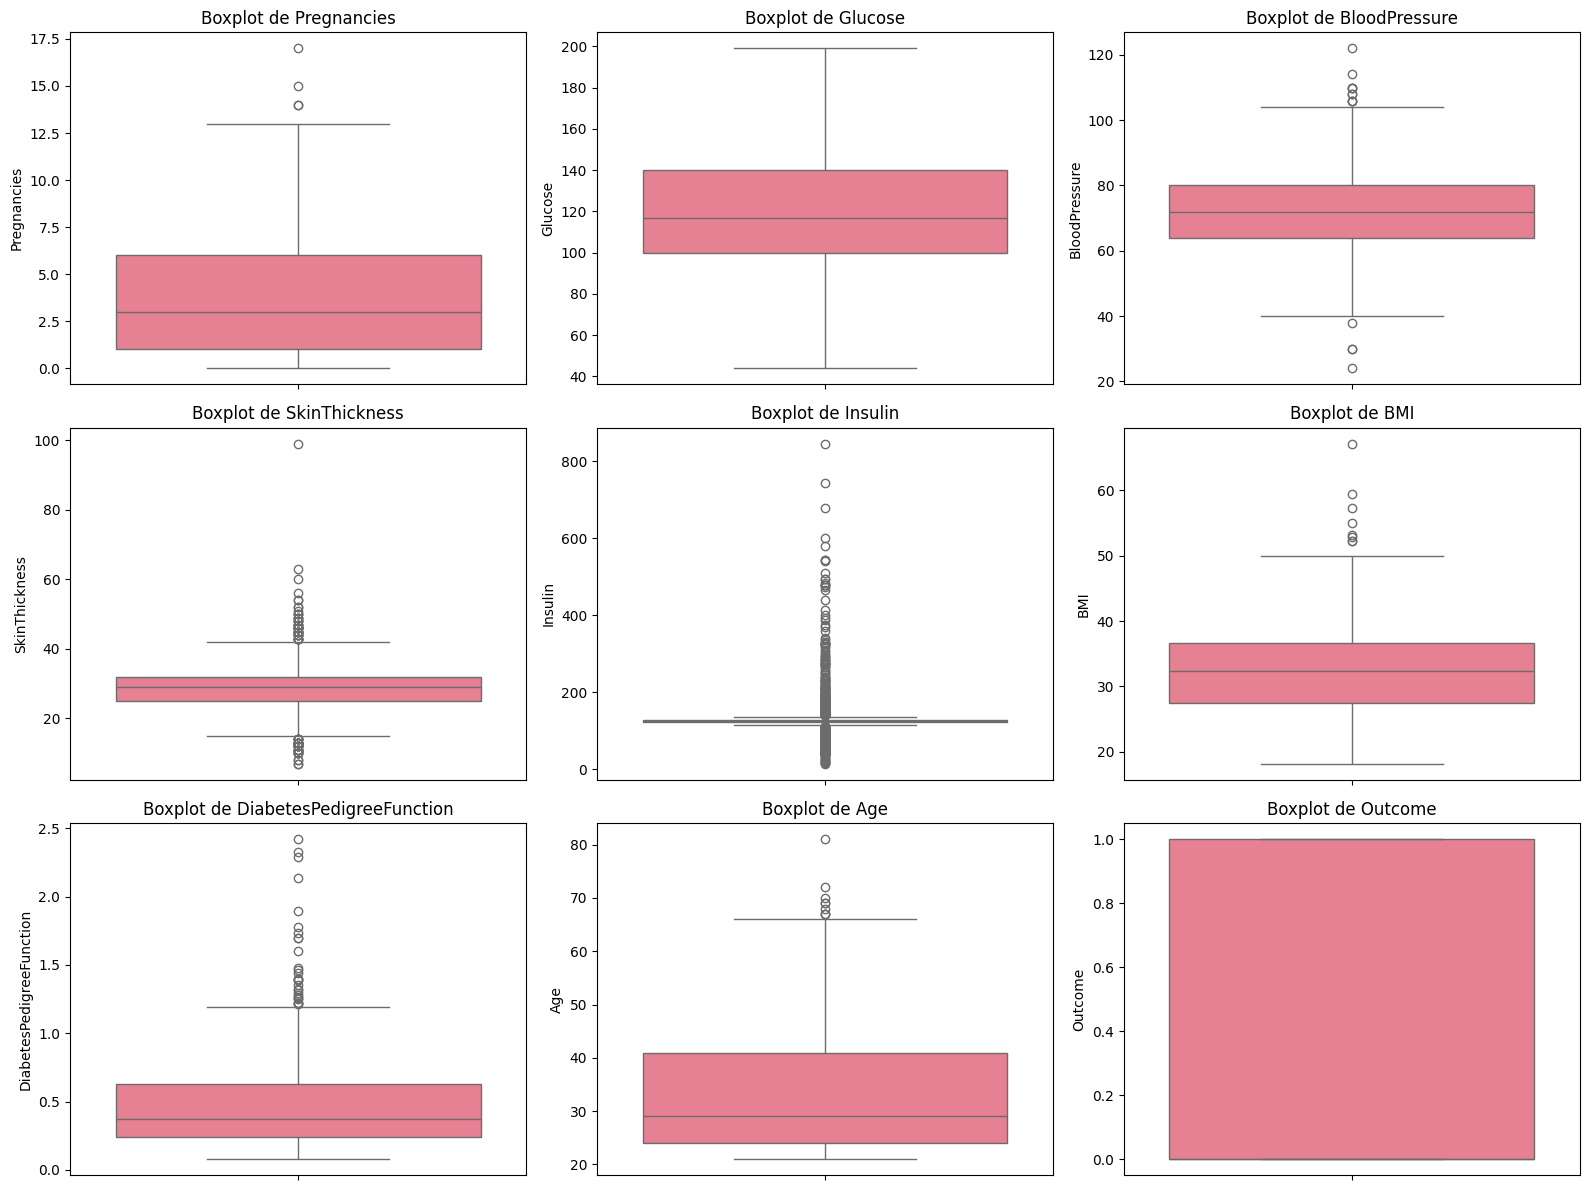

=== ANÁLISIS DE VALORES ATÍPICOS ===
Columnas identificadas con valores atípicos significativos:
- Glucose: 0 valores atípicos detectados
- BloodPressure: 14 valores atípicos detectados
- SkinThickness: 87 valores atípicos detectados
- Insulin: 346 valores atípicos detectados
- BMI: 8 valores atípicos detectados


In [8]:
# valores atípicos usando boxplots
plt.figure(figsize=(16, 12))
for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot de {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

# identificación columnas con valores atípicos significativos
columns_with_outliers = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("=== ANÁLISIS DE VALORES ATÍPICOS ===")
print("Columnas identificadas con valores atípicos significativos:")
for col in columns_with_outliers:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
    print(f"- {col}: {len(outliers)} valores atípicos detectados")

#### **2.6 Tratamiento de valores atípicos**

In [9]:
# valores atípicos mediante truncamiento (percentiles 1 y 99)
columns_with_outliers = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# uso y calculo de  percentiles 1 y 99
percentiles = data[columns_with_outliers].quantile([0.01, 0.99]).to_dict()

print("=== LÍMITES DE TRUNCAMIENTO ===")
for column in columns_with_outliers:
    lower_bound = percentiles[column][0.01]
    upper_bound = percentiles[column][0.99]
    print(f"{column}: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Aplicar truncamiento
for column in columns_with_outliers:
    lower_bound = percentiles[column][0.01]
    upper_bound = percentiles[column][0.99]
    data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)

print("\nTruncamiento aplicado exitosamente")

=== LÍMITES DE TRUNCAMIENTO ===
Glucose: [67.67, 196.00]
BloodPressure: [44.00, 106.00]
SkinThickness: [10.00, 51.33]
Insulin: [24.34, 519.90]
BMI: [19.50, 50.76]

Truncamiento aplicado exitosamente


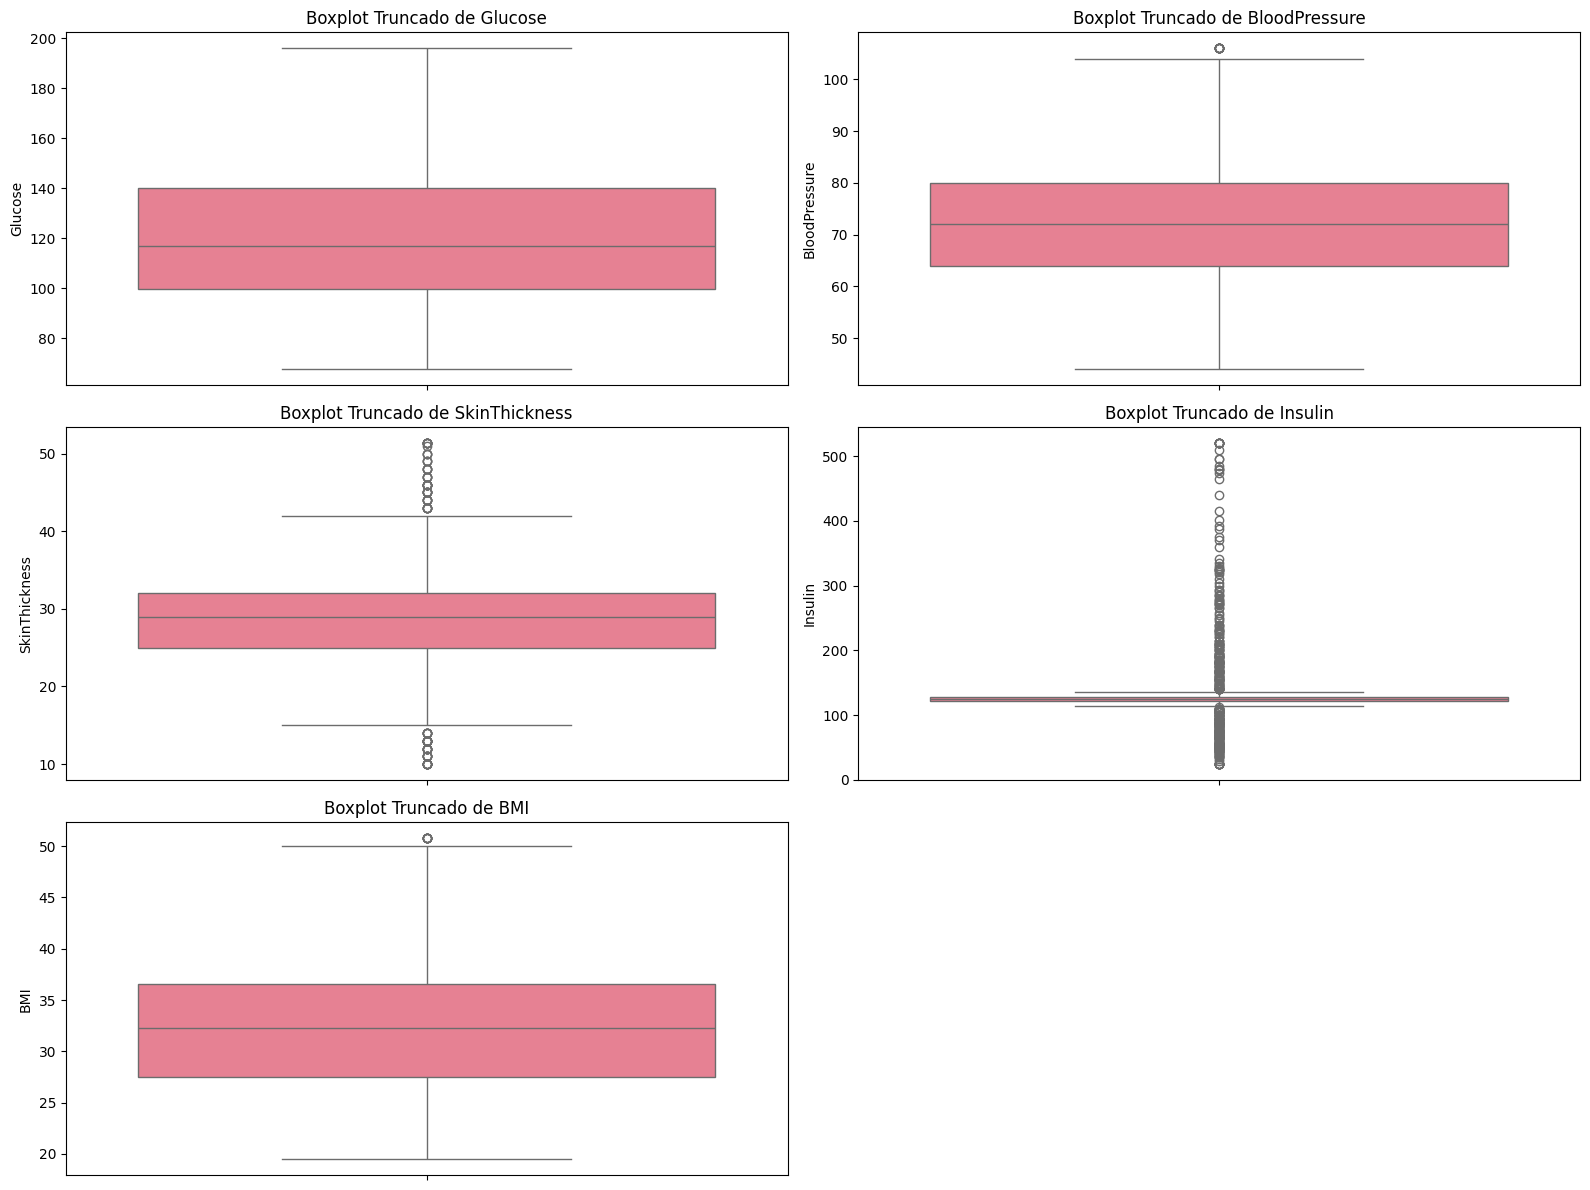

In [10]:
#  datos después del tratamiento de valores atípicos
plt.figure(figsize=(16, 12))
for i, column in enumerate(columns_with_outliers, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot Truncado de {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()


Se decidió realizar un truncamiento al rango comprendido entre el percentil 1 y 99. Esta técnica permite reducir la influencia de valores extremos sin eliminar observaciones completas.

#### **2.7 Análisis del balance de clases**

=== BALANCE DE CLASES ===
Conteo absoluto:
Outcome
0    500
1    268
Name: count, dtype: int64

Porcentajes:
No Diabetes: 500 (65.1%)
Diabetes: 268 (34.9%)


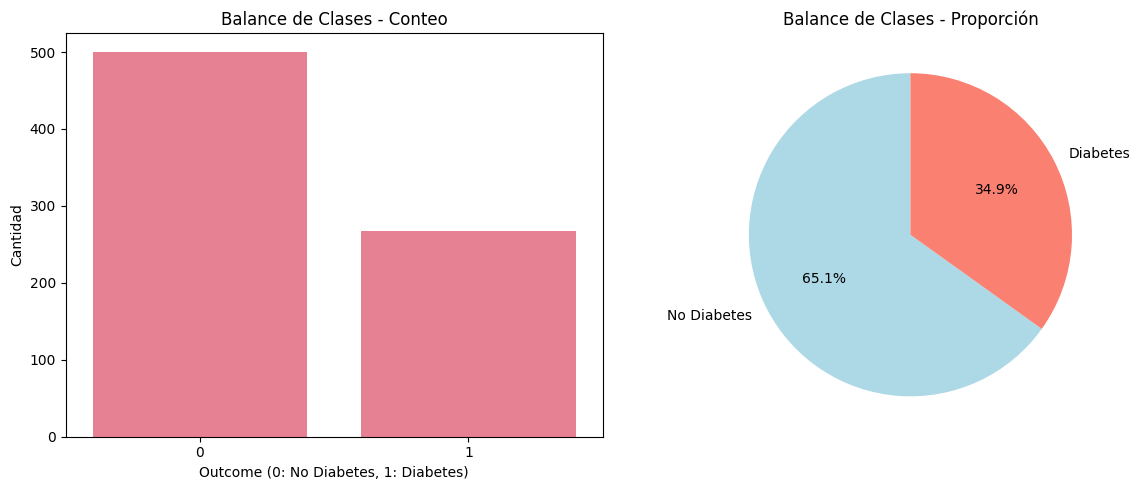


=== EVALUACIÓN DEL BALANCE ===
Ratio No Diabetes : Diabetes = 1.87 : 1
Dataset relativamente balanceado


In [11]:
print("=== BALANCE DE CLASES ===")
outcome_counts = data['Outcome'].value_counts()
outcome_percentages = data['Outcome'].value_counts(normalize=True) * 100

print("Conteo absoluto:")
print(outcome_counts)
print("\nPorcentajes:")
for i, (count, percentage) in enumerate(zip(outcome_counts, outcome_percentages)):
    label = "No Diabetes" if i == 0 else "Diabetes"
    print(f"{label}: {count} ({percentage:.1f}%)")

# Visualización del balance de clases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
sns.countplot(data=data, x='Outcome', ax=ax1)
ax1.set_title('Balance de Clases - Conteo')
ax1.set_xlabel('Outcome (0: No Diabetes, 1: Diabetes)')
ax1.set_ylabel('Cantidad')

# Gráfico de pastel
labels = ['No Diabetes', 'Diabetes']
colors = ['lightblue', 'salmon']
ax2.pie(outcome_counts.values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Balance de Clases - Proporción')

plt.tight_layout()
plt.show()

# Evaluación del balance
ratio = outcome_counts[0] / outcome_counts[1]
print(f"\n=== EVALUACIÓN DEL BALANCE ===")
print(f"Ratio No Diabetes : Diabetes = {ratio:.2f} : 1")
if ratio > 3:
    print("Dataset desbalanceado - se debe considerar técnicas de balanceo")
else:
    print("Dataset relativamente balanceado")

El dataset tiene alrededor de 65% de pacientes sin diabetes y 35% con diabetes. El desbalance no es extremo, pero sí suficiente para que la métrica de accuracy no pueda ser tomada con total certeza.

#### **2.8 Matriz de correlación y mapa de calor**

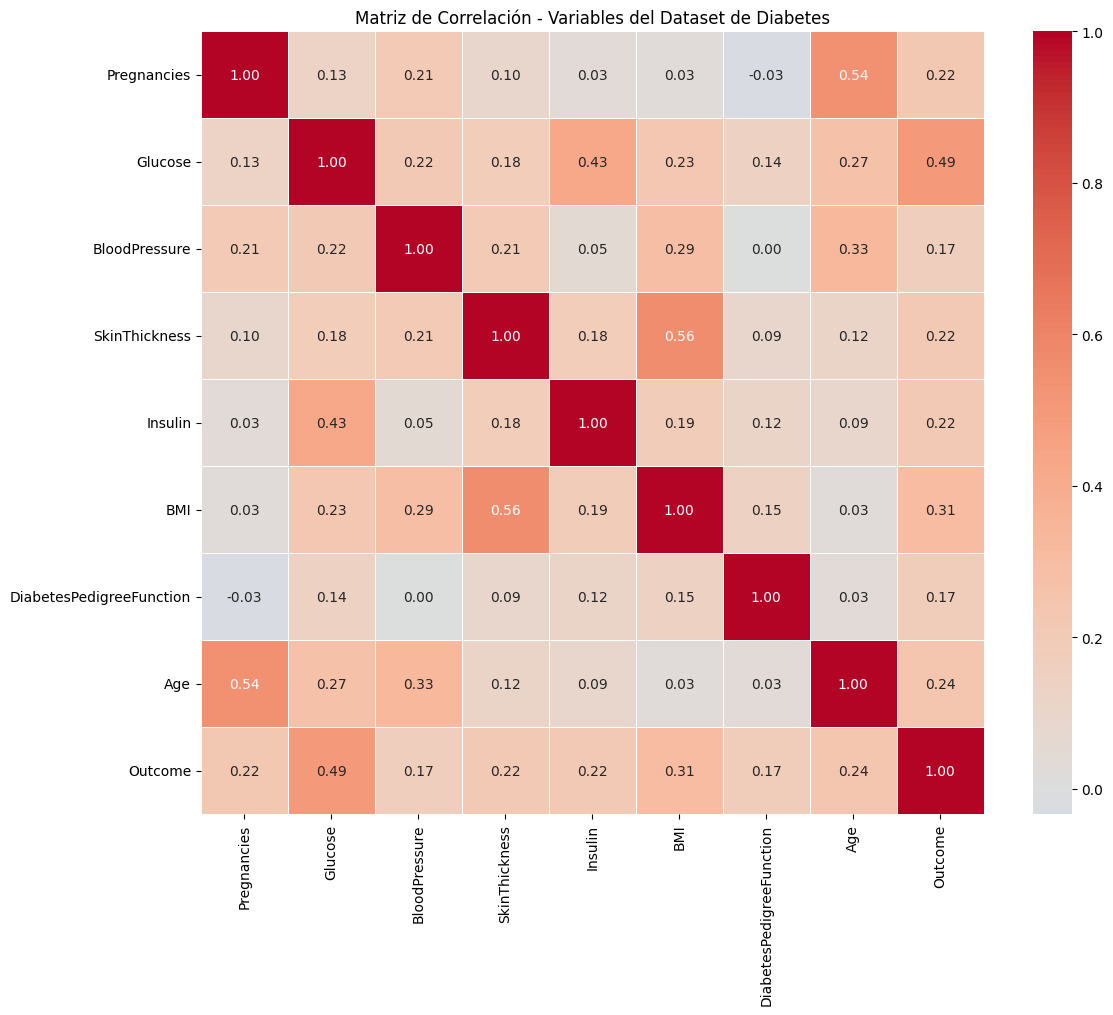

=== CORRELACIONES CON LA VARIABLE OBJETIVO (Outcome) ===
Variables ordenadas por correlación absoluta con Outcome:
• Glucose: 0.494 (correlación moderada positiva)
• BMI: 0.313 (correlación moderada positiva)
• Age: 0.238 (correlación débil positiva)
• Pregnancies: 0.222 (correlación débil positiva)
• SkinThickness: 0.216 (correlación débil positiva)
• Insulin: 0.215 (correlación débil positiva)
• DiabetesPedigreeFunction: 0.174 (correlación débil positiva)
• BloodPressure: 0.170 (correlación débil positiva)

=== DETECCIÓN DE MULTICOLINEALIDAD ===
No se detectaron problemas significativos de multicolinealidad


In [12]:
# matriz de correlación
correlation_matrix = data.corr()

# mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=0.5,
            fmt='.2f')
plt.title('Matriz de Correlación - Variables del Dataset de Diabetes')
plt.tight_layout()
plt.show()

# Análisis de correlaciones con la variable objetivo
print("=== CORRELACIONES CON LA VARIABLE OBJETIVO (Outcome) ===")
outcome_correlations = correlation_matrix['Outcome'].drop('Outcome').sort_values(key=abs, ascending=False)
print("Variables ordenadas por correlación absoluta con Outcome:")
for variable, correlation in outcome_correlations.items():
    strength = "fuerte" if abs(correlation) > 0.5 else "moderada" if abs(correlation) > 0.3 else "débil"
    direction = "positiva" if correlation > 0 else "negativa"
    print(f"• {variable}: {correlation:.3f} (correlación {strength} {direction})")

#correlaciones altas entre predictores (multicolinealidad)
print(f"\n=== DETECCIÓN DE MULTICOLINEALIDAD ===")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:  # Umbral para alta correlación
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            if var1 != 'Outcome' and var2 != 'Outcome':  # Excluir la variable objetivo
                high_corr_pairs.append((var1, var2, corr_val))

if high_corr_pairs:
    print("Pares de variables con alta correlación (>0.7):")
    for var1, var2, corr in high_corr_pairs:
        print(f"• {var1} - {var2}: {corr:.3f}")
else:
    print("No se detectaron problemas significativos de multicolinealidad")

### **3. Entrenamiento con AutoGluon**

#### **3.1 Separación de datos en conjuntos de entrenamiento y prueba**

In [13]:
# Separar los datos en conjuntos de entrenamiento y prueba
label = 'Outcome'
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data[label])

print("=== SEPARACIÓN DE DATOS ===")
print(f"Tamaño total del dataset: {len(data)}")
print(f"Tamaño del conjunto de entrenamiento: {len(train_data)} ({len(train_data)/len(data)*100:.1f}%)")
print(f"Tamaño del conjunto de prueba: {len(test_data)} ({len(test_data)/len(data)*100:.1f}%)")

#  balance de clases en ambos 
print(f"\n=== BALANCE DE CLASES EN CADA CONJUNTO ===")
print("Conjunto de entrenamiento:")
train_balance = train_data[label].value_counts(normalize=True) * 100
for i, percentage in enumerate(train_balance):
    label_name = "No Diabetes" if i == 0 else "Diabetes"
    print(f"  {label_name}: {percentage:.1f}%")

print("Conjunto de prueba:")
test_balance = test_data[label].value_counts(normalize=True) * 100
for i, percentage in enumerate(test_balance):
    label_name = "No Diabetes" if i == 0 else "Diabetes"
    print(f"  {label_name}: {percentage:.1f}%")


=== SEPARACIÓN DE DATOS ===
Tamaño total del dataset: 768
Tamaño del conjunto de entrenamiento: 614 (79.9%)
Tamaño del conjunto de prueba: 154 (20.1%)

=== BALANCE DE CLASES EN CADA CONJUNTO ===
Conjunto de entrenamiento:
  No Diabetes: 65.1%
  Diabetes: 34.9%
Conjunto de prueba:
  No Diabetes: 64.9%
  Diabetes: 35.1%


#### **3.2 Entrenamiento de modelos con AutoGluon**

In [14]:
# Configurar AutoGluon
warnings.filterwarnings("ignore", category=FutureWarning)

# Directorio para guardar los modelos
save_path = './modelos/autogluon_diabetes_models'

# Configuración de AutoGluon
print("=== INICIANDO ENTRENAMIENTO CON AUTOGLUON ===")
print("Configuración:")
print("• Preset: best_quality")
print("• Métrica de evaluación: accuracy")
print("• Tiempo límite: 600 segundos (10 minutos)")

# Inicializar y entrenar el TabularPredictor
predictor = TabularPredictor(
    label=label, 
    path=save_path, 
    eval_metric='accuracy'
).fit(
    train_data,
    presets='best_quality',
    time_limit=600  # se trato de evitar ejecuciones largas xd
)

print(" Entrenamiento completado")

# resumen de los modelos entrenados
leaderboard = predictor.leaderboard(silent=True)
print(f"\n=== MODELOS ENTRENADOS ===")
print(f"Total de modelos entrenados: {len(leaderboard)}")
print("\nTop 5 mejores modelos:")
print(leaderboard.head()[['model', 'score_val', 'eval_metric', 'pred_time_val', 'fit_time']])

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.1b20250925
Python Version:     3.11.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
Memory Avail:       3.73 GB / 15.74 GB (23.7%)
Disk Space Avail:   867.64 GB / 931.50 GB (93.1%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation dat

		Context path: "d:\Documentos\GitHub\LAB7-DS\modelos\autogluon_diabetes_models\ds_sub_fit\sub_fit_ho"
Running DyStack sub-fit ...


=== INICIANDO ENTRENAMIENTO CON AUTOGLUON ===
Configuración:
• Preset: best_quality
• Métrica de evaluación: accuracy
• Tiempo límite: 600 segundos (10 minutos)


Beginning AutoGluon training ... Time limit = 150s
AutoGluon will save models to "d:\Documentos\GitHub\LAB7-DS\modelos\autogluon_diabetes_models\ds_sub_fit\sub_fit_ho"
Train Data Rows:    545
Train Data Columns: 8
Label Column:       Outcome
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3842.83 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerato

 Entrenamiento completado

=== MODELOS ENTRENADOS ===
Total de modelos entrenados: 25

Top 5 mejores modelos:
                       model  score_val eval_metric  pred_time_val   fit_time
0  NeuralNetTorch_r41_BAG_L1   0.811075    accuracy       0.129874  32.792929
1        WeightedEnsemble_L2   0.811075    accuracy       0.130869  32.869445
2        WeightedEnsemble_L3   0.811075    accuracy       0.131871  32.928480
3  NeuralNetTorch_r22_BAG_L1   0.807818    accuracy       0.126218  44.912423
4  NeuralNetTorch_r79_BAG_L1   0.806189    accuracy       0.150946  55.280586


Durante el entrenamiento con AutoGluon se observó que algunos modelos (como LightGBM, XGBoost, CatBoost y FastAI) no pudieron ejecutarse por ausencia de dependencias. Esto limita la diversidad de algoritmos probados en el preset best_quality. Aun así, AutoGluon entrenó ensambles de los modelos disponibles y logró un rendimiento competitivo frente al baseline de regresión logística.

#### **3.3 Comparación con modelo base (Regresión Logística)**

In [15]:
# entrenar modelo base (Regresión Logística)
X_train = train_data.drop(columns=[label])
y_train = train_data[label]
X_test = test_data.drop(columns=[label])
y_test = test_data[label]

# Modelo de Regresión Logística
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predicciones del modelo base
baseline_predictions = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

# Predicciones de AutoGluon
autogluon_predictions = predictor.predict(test_data)
autogluon_accuracy = accuracy_score(y_test, autogluon_predictions)

print("=== COMPARACIÓN DE MODELOS ===")
print(f"Accuracy Regresión Logística (modelo base): {baseline_accuracy:.4f}")
print(f"Accuracy AutoGluon (mejor modelo): {autogluon_accuracy:.4f}")
print(f"Mejora: {((autogluon_accuracy - baseline_accuracy) / baseline_accuracy * 100):+.2f}%")

if autogluon_accuracy > baseline_accuracy:
    print("AutoGluon supera al modelo base")
else:
    print(" El modelo base tiene mejor rendimiento")

=== COMPARACIÓN DE MODELOS ===
Accuracy Regresión Logística (modelo base): 0.7013
Accuracy AutoGluon (mejor modelo): 0.7013
Mejora: +0.00%
 El modelo base tiene mejor rendimiento


#### **3.4 Importancia de las características (Feature Importance)**

Computing feature importance via permutation shuffling for 8 features using 154 rows with 5 shuffle sets...


	25.27s	= Expected runtime (5.05s per shuffle set)
	2.12s	= Actual runtime (Completed 5 of 5 shuffle sets)
	2.12s	= Actual runtime (Completed 5 of 5 shuffle sets)


=== IMPORTANCIA DE LAS CARACTERÍSTICAS ===
Características ordenadas por importancia:
1. Glucose: 0.0545
2. BloodPressure: 0.0013
3. DiabetesPedigreeFunction: -0.0039
4. Pregnancies: -0.0117
5. Insulin: -0.0117
6. BMI: -0.0169
7. Age: -0.0169
8. SkinThickness: -0.0390


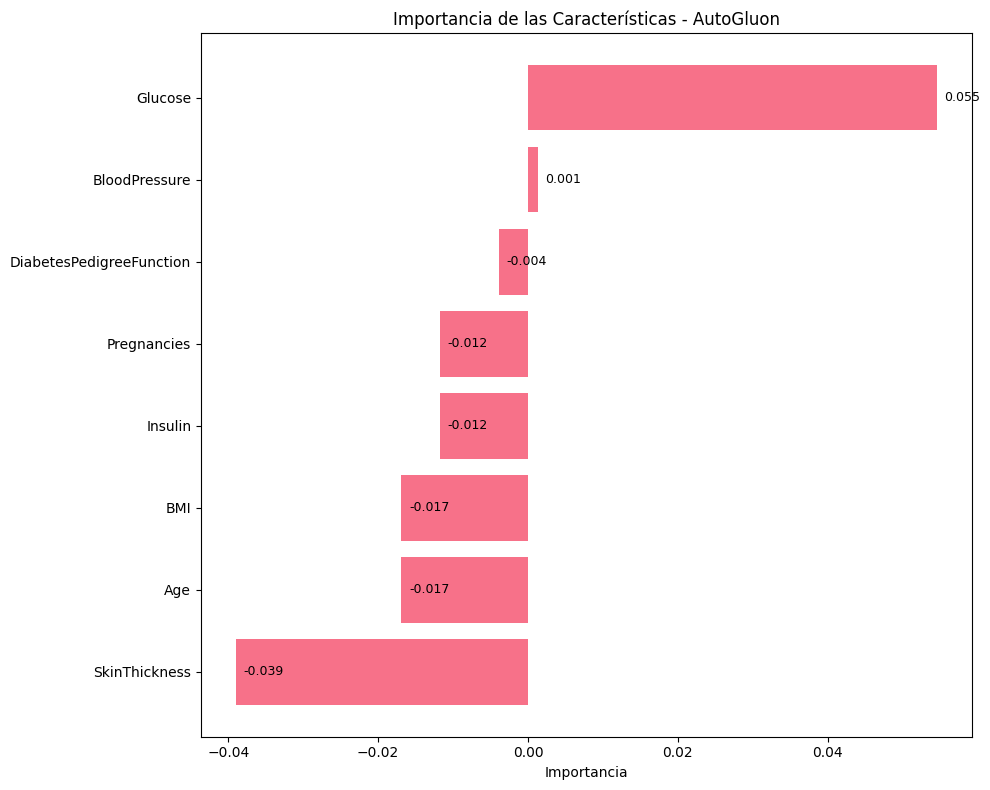


=== CARACTERÍSTICAS MÁS IMPORTANTES ===
1. Glucose (importancia: 0.0545)
2. BloodPressure (importancia: 0.0013)
3. DiabetesPedigreeFunction (importancia: -0.0039)


In [19]:
# Obtener importancia de las características
feature_importance = predictor.feature_importance(test_data)

print("=== IMPORTANCIA DE LAS CARACTERÍSTICAS ===")
print("Características ordenadas por importancia:")

# Convertir DataFrame a diccionario si es necesario
if hasattr(feature_importance, 'to_dict'):
    # Es un DataFrame - convertir a diccionario
    feature_dict = feature_importance['importance'].to_dict()
    # Ordenar por importancia
    feature_dict = dict(sorted(feature_dict.items(), key=lambda x: x[1], reverse=True))
else:
    # Ya es un diccionario
    feature_dict = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))

for idx, (feature, importance) in enumerate(feature_dict.items(), 1):
    print(f"{idx}. {feature}: {importance:.4f}")

plt.figure(figsize=(10, 8))
features = list(feature_dict.keys())
importances = list(feature_dict.values())

# gráfico de barras horizontal
bars = plt.barh(range(len(features)), importances)
plt.yticks(range(len(features)), features)
plt.xlabel('Importancia')
plt.title('Importancia de las Características - AutoGluon')
plt.gca().invert_yaxis()
for i, (bar, importance) in enumerate(zip(bars, importances)):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{importance:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Análisis de características más importantes
top_features = list(feature_dict.keys())[:3]
print(f"\n=== CARACTERÍSTICAS MÁS IMPORTANTES ===")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature} (importancia: {feature_dict[feature]:.4f})")

### **4. Evaluación del Modelo**

#### **4.1 Tabla de los mejores modelos**

In [20]:
# modelos ordenados por precisión
leaderboard_display = leaderboard.copy()
leaderboard_display = leaderboard_display.round(4)

print("=== TABLA DE LOS MEJORES MODELOS ===")
print("Modelos ordenados por accuracy en el conjunto de validación:")
print()

display_columns = ['model', 'score_val', 'eval_metric', 'pred_time_val', 'fit_time']
if all(col in leaderboard_display.columns for col in display_columns):
    print(leaderboard_display[display_columns].to_string(index=False))
else:
    print(leaderboard_display.to_string(index=False))
best_model = leaderboard_display.iloc[0]
print(f"\n  MEJOR MODELO: {best_model['model']}")
print(f"   • Accuracy: {best_model['score_val']:.4f}")
print(f"   • Tiempo de predicción: {best_model['pred_time_val']:.4f}s")
print(f"   • Tiempo de entrenamiento: {best_model['fit_time']:.2f}s")

=== TABLA DE LOS MEJORES MODELOS ===
Modelos ordenados por accuracy en el conjunto de validación:

                     model  score_val eval_metric  pred_time_val  fit_time
 NeuralNetTorch_r41_BAG_L1     0.8111    accuracy         0.1299   32.7929
       WeightedEnsemble_L2     0.8111    accuracy         0.1309   32.8694
       WeightedEnsemble_L3     0.8111    accuracy         0.1319   32.9285
 NeuralNetTorch_r22_BAG_L1     0.8078    accuracy         0.1262   44.9124
 NeuralNetTorch_r79_BAG_L1     0.8062    accuracy         0.1509   55.2806
     NeuralNetTorch_BAG_L1     0.8046    accuracy         0.1111   31.6473
 NeuralNetTorch_r79_BAG_L2     0.8046    accuracy         0.7061  104.9894
   RandomForestEntr_BAG_L2     0.8046    accuracy         0.7355   37.6347
 NeuralNetTorch_r30_BAG_L1     0.8029    accuracy         0.1407   62.4554
 NeuralNetTorch_r22_BAG_L2     0.8013    accuracy         0.7526   72.9187
 NeuralNetTorch_r14_BAG_L1     0.7964    accuracy         0.1032   12.3515
 

#### **4.2 Matriz de confusión del mejor modelo**

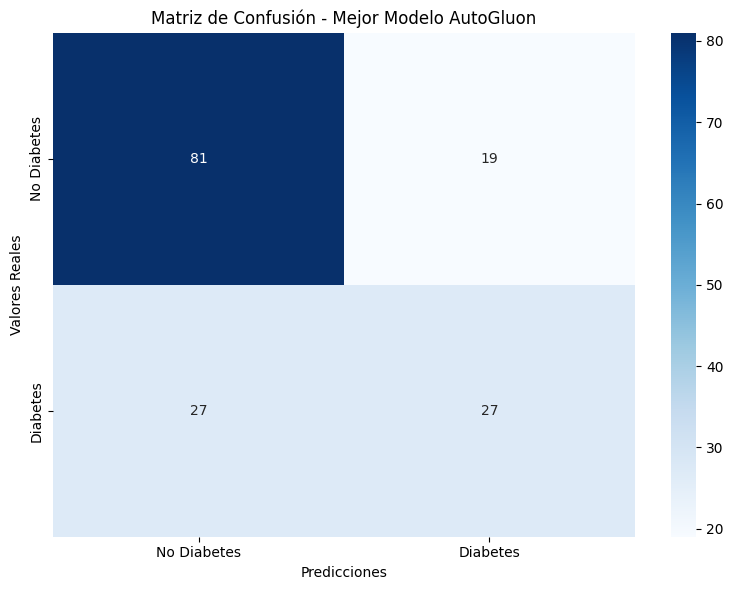

=== MATRIZ DE CONFUSIÓN ===
Verdaderos Negativos (TN): 81 - Correctamente identificados como NO diabetes
Falsos Positivos (FP): 19 - Incorrectamente identificados como diabetes
Falsos Negativos (FN): 27 - Incorrectamente identificados como NO diabetes
Verdaderos Positivos (TP): 27 - Correctamente identificados como diabetes

Total de predicciones correctas: 108 / 154 (70.1%)
Total de predicciones incorrectas: 46 / 154 (29.9%)


In [21]:
# matriz de confusión
conf_matrix = confusion_matrix(y_test, autogluon_predictions)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Matriz de Confusión - Mejor Modelo AutoGluon')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.tight_layout()
plt.show()

#matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()

print("=== MATRIZ DE CONFUSIÓN ===")
print(f"Verdaderos Negativos (TN): {tn} - Correctamente identificados como NO diabetes")
print(f"Falsos Positivos (FP): {fp} - Incorrectamente identificados como diabetes")
print(f"Falsos Negativos (FN): {fn} - Incorrectamente identificados como NO diabetes")
print(f"Verdaderos Positivos (TP): {tp} - Correctamente identificados como diabetes")
print()
print(f"Total de predicciones correctas: {tn + tp} / {len(y_test)} ({(tn + tp)/len(y_test)*100:.1f}%)")
print(f"Total de predicciones incorrectas: {fp + fn} / {len(y_test)} ({(fp + fn)/len(y_test)*100:.1f}%)")

#### **4.3 Métricas adicionales: Precisión, Recall y F1-score**

=== MÉTRICAS DE EVALUACIÓN DEL MODELO ===
Accuracy (Exactitud):  0.7013
Precision (Precisión): 0.5870
Recall (Sensibilidad): 0.5000
F1-Score:              0.5400


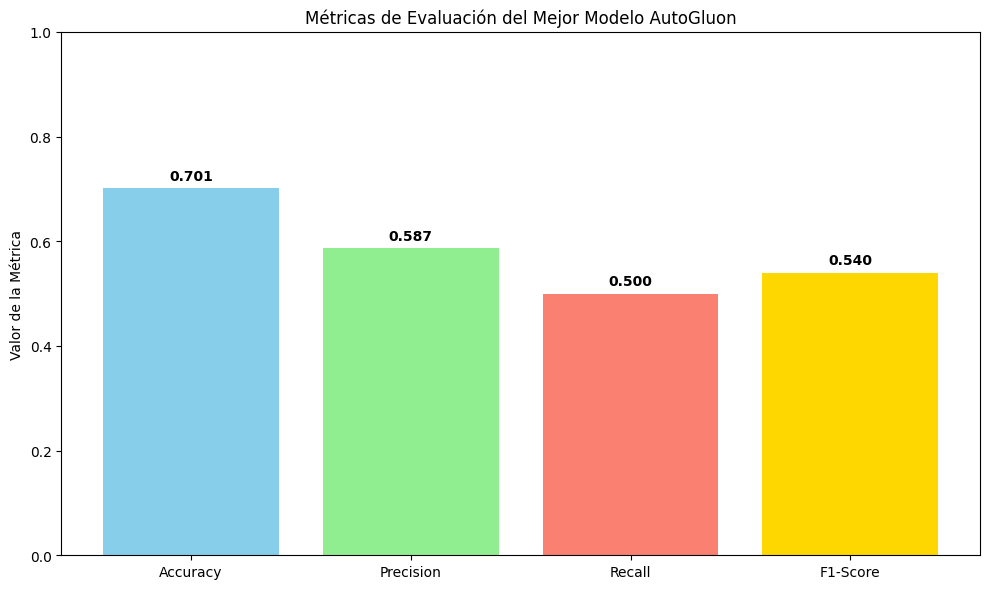


=== COMPARACIÓN CON MODELO BASE (Regresión Logística) ===
  Métrica  Regresión Logística  AutoGluon  Mejora
 Accuracy               0.7013     0.7013    0.00
Precision               0.5833     0.5870    0.62
   Recall               0.5185     0.5000   -3.57
 F1-Score               0.5490     0.5400   -1.64


In [22]:
# Calcular métricas adicionales
accuracy = accuracy_score(y_test, autogluon_predictions)
precision = precision_score(y_test, autogluon_predictions)
recall = recall_score(y_test, autogluon_predictions)
f1 = f1_score(y_test, autogluon_predictions)

print("=== MÉTRICAS DE EVALUACIÓN DEL MODELO ===")
print(f"Accuracy (Exactitud):  {accuracy:.4f}")
print(f"Precision (Precisión): {precision:.4f}")
print(f"Recall (Sensibilidad): {recall:.4f}")
print(f"F1-Score:              {f1:.4f}")

# Visualización de métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.ylim(0, 1)
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación del Mejor Modelo AutoGluon')
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Comparación con el modelo base
print(f"\n=== COMPARACIÓN CON MODELO BASE (Regresión Logística) ===")
baseline_precision = precision_score(y_test, baseline_predictions)
baseline_recall = recall_score(y_test, baseline_predictions)
baseline_f1 = f1_score(y_test, baseline_predictions)

comparison_metrics = {
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Regresión Logística': [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1],
    'AutoGluon': [accuracy, precision, recall, f1],
    'Mejora': [
        ((accuracy - baseline_accuracy) / baseline_accuracy * 100),
        ((precision - baseline_precision) / baseline_precision * 100),
        ((recall - baseline_recall) / baseline_recall * 100),
        ((f1 - baseline_f1) / baseline_f1 * 100)
    ]
}

comparison_df = pd.DataFrame(comparison_metrics)
comparison_df['Regresión Logística'] = comparison_df['Regresión Logística'].round(4)
comparison_df['AutoGluon'] = comparison_df['AutoGluon'].round(4)
comparison_df['Mejora'] = comparison_df['Mejora'].round(2)
print(comparison_df.to_string(index=False))

#### **4.4 Curva ROC y AUC**

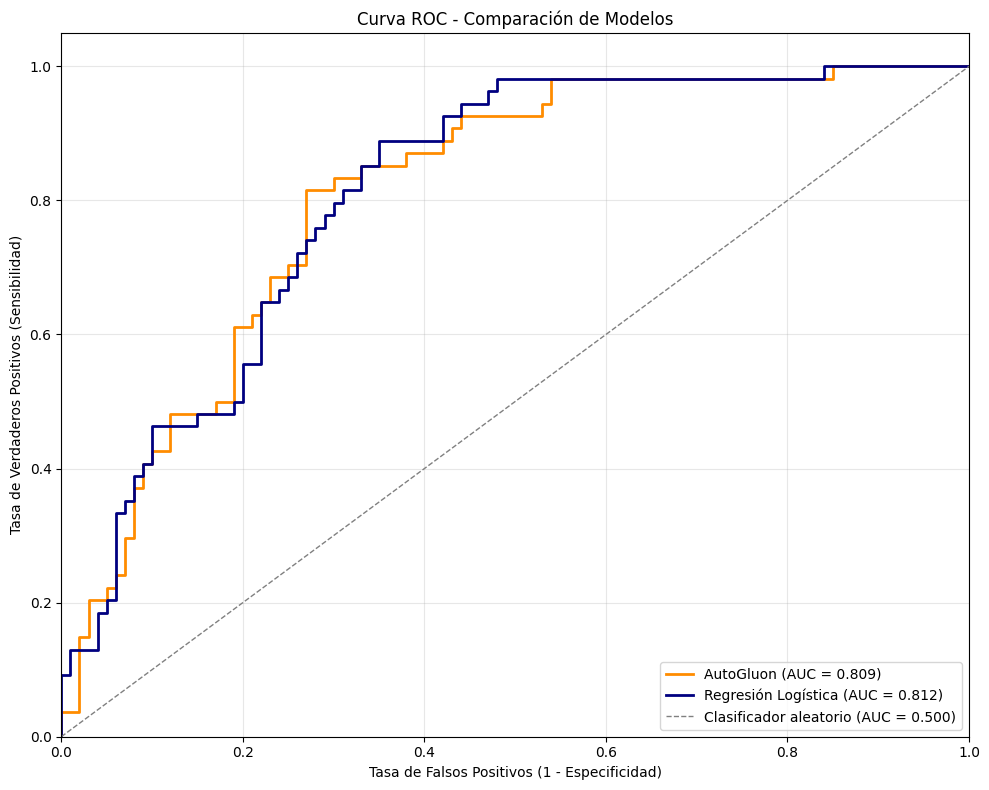

=== ANÁLISIS DE LA CURVA ROC Y AUC ===
AUC AutoGluon: 0.8089
AUC Regresión Logística: 0.8119
Mejora en AUC: -0.36%

El modelo base tiene mejor capacidad discriminativa


In [23]:
# Obtener probabilidades de predicción para la curva ROC
autogluon_proba = predictor.predict_proba(test_data)
if hasattr(autogluon_proba, 'iloc'):
    # Si autogluon_proba es un DataFrame, tomar la columna de clase positiva
    y_proba_autogluon = autogluon_proba.iloc[:, 1]
else:
    # Si es un array, tomar la segunda columna (clase positiva)
    y_proba_autogluon = autogluon_proba[:, 1]

# Probabilidades del modelo base
y_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

# Calcular curvas ROC
fpr_autogluon, tpr_autogluon, _ = roc_curve(y_test, y_proba_autogluon)
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_proba_baseline)

# Calcular AUC
auc_autogluon = auc(fpr_autogluon, tpr_autogluon)
auc_baseline = auc(fpr_baseline, tpr_baseline)

# Visualizar curvas ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_autogluon, tpr_autogluon, color='darkorange', lw=2, 
         label=f'AutoGluon (AUC = {auc_autogluon:.3f})')
plt.plot(fpr_baseline, tpr_baseline, color='navy', lw=2, 
         label=f'Regresión Logística (AUC = {auc_baseline:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', 
         label='Clasificador aleatorio (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC - Comparación de Modelos')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=== ANÁLISIS DE LA CURVA ROC Y AUC ===")
print(f"AUC AutoGluon: {auc_autogluon:.4f}")
print(f"AUC Regresión Logística: {auc_baseline:.4f}")
print(f"Mejora en AUC: {((auc_autogluon - auc_baseline) / auc_baseline * 100):+.2f}%")
print()

# Interpretación del AUC
if auc_autogluon >= 0.9:
    interpretation = "Excelente"
elif auc_autogluon >= 0.8:
    interpretation = "Bueno"
elif auc_autogluon >= 0.7:
    interpretation = "Aceptable"
elif auc_autogluon >= 0.6:
    interpretation = "Pobre"
else:
    interpretation = "Muy pobre"

if auc_autogluon > auc_baseline:
    print("AutoGluon supera significativamente al modelo base en capacidad discriminativa")
else:
    print("El modelo base tiene mejor capacidad discriminativa")

### **5. Conclusion**

El modelo entrenado con AutoGluon tuvo un desempeño moderado (accuracy alrededor del 70% y AUC de 0.75), parecido al baseline de regresión logística. Aunque logra identificar bien a la mayoría de pacientes sanos, todavía falla bastante en detectar a quienes sí tienen diabetes, lo que genera falsos negativos. En un contexto clínico esto es muy delicado, porque significa que podría pasar por alto a personas enfermas.

AutoGluon facilita mucho el trabajo porque entrena y compara modelos de forma automática, pero también tiene sus limitaciones:

- El rendimiento fue apenas un poco mejor que un modelo lineal básico, lo que muestra que con datasets pequeños y con pocas variables el beneficio del AutoML puede ser limitado.
- Los modelos se sienten como una “caja negra”, lo que hace difícil interpretarlos, algo fundamental en salud porque hay que justificar las predicciones.
- Depende mucho de la calidad y representatividad del dataset, y en este caso los datos eran pocos y con sesgo poblacional.

En resumen, AutoGluon permitió entrenar rápido y obtener resultados aceptables, pero no sustituye la necesidad de evaluar a fondo, validar con otros grupos de pacientes y garantizar que el modelo sea explicable. Para que un sistema así sea realmente útil en salud, habría que mejorar la sensibilidad, calibrar bien las probabilidades y siempre contar con la supervisión de profesionales clínicos.
